In [1]:
# note: fdfdpy and nonlinear_avm must be in PATH
from fdfdpy.Fdfd import Fdfd
from nonlinear_solvers import born_solve, newton_solve
from optimization import run_optimization

import numpy as np
import matplotlib.pylab as plt
import scipy.sparse as sp

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
omega = 5e14                # angular frequency (2pi)
dl = 1e-1                   # grid size (m)
eps_r = np.ones((100,100))  # relative permittivity
eps_r[40:60, 40:60] = 5     # define box
NPML = [10, 10]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')

In [3]:
# sets simulation variables, constructs system matrix 'A', stored in 'simulation' object
simulation = Fdfd(omega,eps_r,dl,NPML,pol)

In [4]:
# set source and solve for electromagnetic fields
b = np.zeros((simulation.Nx,simulation.Ny))
b[40:60,30] = 1
(Hx,Hy,Ez) = simulation.solve_fields(b)

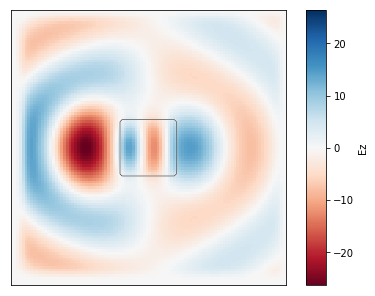

In [5]:
# plot
simulation.plt_re(outline=True, cbar=True);

In [6]:
# This is where we define stuff for the optimization

eps_max = 5
Nsteps = 1000
Jregion = np.zeros(eps_r.shape)
Jregion[50, 80] = 1

# define linear and nonlinear parts of objective function + the total objective function form
J = {}
J['linear']    = lambda e: np.sum(np.square(np.abs(e*Jregion)))
J['nonlinear'] = lambda e: np.sum(np.square(np.abs(e*Jregion)))
J['total']     = lambda J_lin, J_nonlin: J_lin - J_nonlin

# define linear and nonlinear parts of dJdE + the total derivative form
dJdE = {}
dJdE['linear']    = lambda e: np.conj(e)*Jregion
dJdE['nonlinear'] = lambda e: np.conj(e)*Jregion
dJdE['total']     = lambda dJdE_lin, dJdE_nonlin: dJdE_lin - dJdE_nonlin

# define the design and nonlinear regions
design_region = np.array(eps_r > 1).astype(int)
regions = {}
regions['design'] = design_region
regions['nonlin'] = design_region

# define the nonlinearity
chi3 = 2.8*1e-18                           # Silcion in m^2/V^2 from Boyd's book
chi3_fdfd = chi3/simulation.L0**2          # In the units of the FDFD solver such that eps_nl = eps_r + 3*chi3_fdfd*|e|^2
kerr_nonlinearity = lambda e: 3*chi3_fdfd*np.square(np.abs(e))
kerr_nl_de = lambda e: 3*chi3_fdfd*np.conj(e)
nonlin_fns = {}
nonlin_fns['deps_de'] = kerr_nonlinearity
nonlin_fns['dnl_de'] = kerr_nl_de

In [7]:
obj_fns = run_optimization(simulation, b, J, dJdE, design_region, Nsteps, eps_max, solver='born', step_size=0.2)

TypeError: run_optimization() missing 1 required positional argument: 'eps_max'

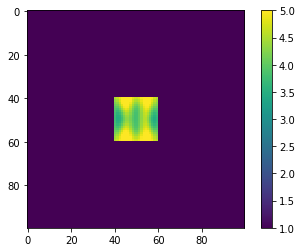

In [8]:
plt.imshow(simulation.eps_r)
plt.colorbar()
plt.show()

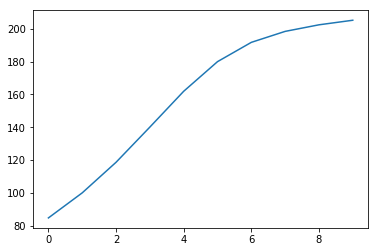

In [9]:
plt.plot(obj_fns)
plt.show()

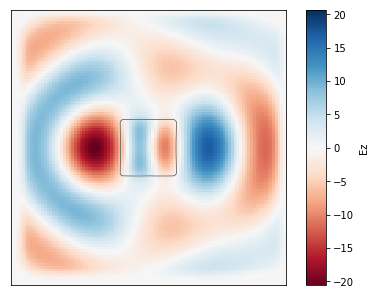

In [10]:
(Hx,Hy,Ez) = simulation.solve_fields(b)
simulation.plt_re()

In [11]:
# Now try running the same thing but with nonlinearity 
# Should be the same for this amount of input power and choice of chi-3

chi3 = 2.8*1e-18         # Silcion in m^2/V^2 from Boyd's book
chi3_fdfd = chi3/simulation.L0**2        # In the units of the FDFD solver such that eps_nl = eps_r + 3*chi3_fdfd*|e|^2
nl_region = design_region  # Nonliearity region
# Define nonlinear function
kerr_nonlinearity = lambda e: 3*chi3_fdfd*np.square(np.abs(e))
# Define the partial derivative of the nonlinear function w.r.t. e
kerr_nl_de = lambda e: 3*chi3_fdfd*np.conj(e)

In [12]:
# Reset simulation
simulation.reset_eps(eps_r)

In [13]:
# define linear and nonlinear parts of objective function + the total objective function form
J = {}
J['nonlinear']    = lambda e: np.sum(np.square(np.abs(e*Jregion)))
J['linear'] = None
J['total']     = lambda Jlin, Jnonlin: Jnonlin

# define linear and nonlinear parts of dJdE + the total derivative form
dJdE = {}
dJdE['nonlinear']    = lambda e: np.conj(e)*Jregion
dJdE['linear'] = None
dJdE['total']     = lambda dJdE_lin, dJdE_nonlin: dJdE_nonlin

In [14]:
obj_fns = run_optimization(simulation, b, J, dJdE, design_region, Nsteps, eps_max, kerr_nonlinearity, nl_region,
                           kerr_nl_de, step_size=0.2)

100% (10 of 10) |########################| Elapsed Time: 0:00:04 ETA:  00:00:00

In [15]:
# Note: takes a bit longer because the nonlinear solvers still need to solve twice to 
# know that the result is converged. Also the adjoint computation probably takes a bit longer
# Results look the same: 

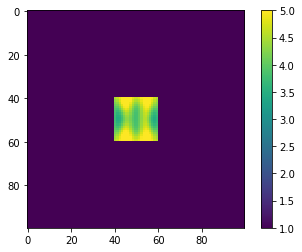

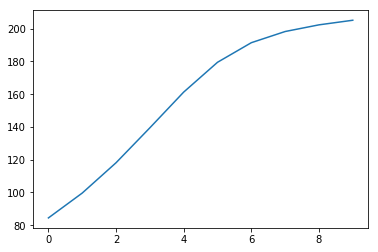

In [16]:
plt.imshow(simulation.eps_r)
plt.colorbar()
plt.show()
plt.plot(obj_fns)
plt.show()

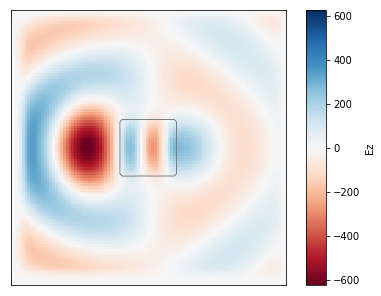

In [17]:
# Now let's try a larger input power
b[40:60,30] = 20
# Reset simulation
simulation.reset_eps(eps_r)
# Solve the nonlinear problem to see that it converges but also differs from linear solution above
from optimization import _solve_nl
(convergence_array) = _solve_nl(simulation, b, kerr_nonlinearity, nl_region, kerr_nl_de, solver='born')
simulation.plt_re(outline=True, cbar=True);

In [18]:
# Reset simulation
simulation.reset_eps(eps_r)
# Try first Born optimization 
# Note: step_size is much smaller because gradient is much larger (total amplitude of |Ez|^2 much larger than above)
# Some onrmalization would be nice
Nsteps = 20
obj_fns = run_optimization(simulation, b, J, dJdE, design_region, Nsteps, eps_max, kerr_nonlinearity, nl_region,
                           kerr_nl_de, solver='born', step_size=0.001)

 45% (9 of 20) |###########              | Elapsed Time: 0:00:19 ETA:   0:00:36

the simulation did not converge, reached 2.493621707256189e-10


 50% (10 of 20) |############            | Elapsed Time: 0:00:22 ETA:   0:00:34

the simulation did not converge, reached 3.4405874196771647e-09


 55% (11 of 20) |#############           | Elapsed Time: 0:00:26 ETA:   0:00:32

the simulation did not converge, reached 3.186052339556282e-08


 60% (12 of 20) |##############          | Elapsed Time: 0:00:29 ETA:   0:00:26

the simulation did not converge, reached 1.792920924479566e-07


 65% (13 of 20) |###############         | Elapsed Time: 0:00:32 ETA:   0:00:24

the simulation did not converge, reached 2.021632302152711e-07


 70% (14 of 20) |################        | Elapsed Time: 0:00:36 ETA:   0:00:20

the simulation did not converge, reached 1.589536695717785e-06


 90% (18 of 20) |#####################   | Elapsed Time: 0:00:49 ETA:   0:00:06

the simulation did not converge, reached 1.2381762139480104e-10


100% (20 of 20) |########################| Elapsed Time: 0:00:57 ETA:  00:00:00

the simulation did not converge, reached 2.8485635974813623e-10
the simulation did not converge, reached 2.1209889095567709e-10


In [19]:
# The simulation did not always reach the default convergence (1e-10). 
# It's a bit unstable, but still correct - see results below

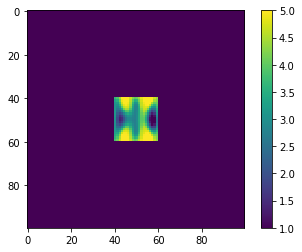

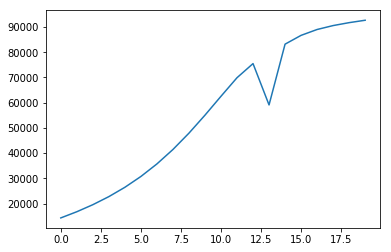

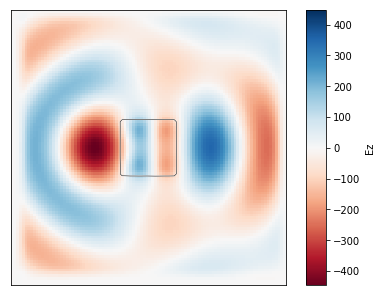

In [20]:
plt.imshow(simulation.eps_r)
plt.colorbar()
plt.show()
plt.plot(obj_fns)
plt.show()
(convergence_array) = _solve_nl(simulation, b, kerr_nonlinearity, nl_region, kerr_nl_de, solver='newton')
simulation.plt_re(outline=True, cbar=True);

In [21]:
# Now let's try Newton
# Reset simulation
simulation.reset_eps(eps_r)
obj_fns = run_optimization(simulation, b, J, dJdE, design_region, Nsteps, eps_max, kerr_nonlinearity, nl_region,
                           kerr_nl_de, solver='newton', step_size=0.001)

100% (20 of 20) |########################| Elapsed Time: 0:00:21 ETA:  00:00:00

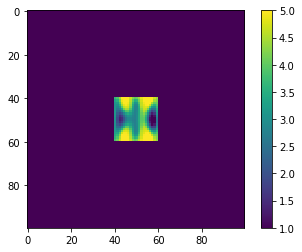

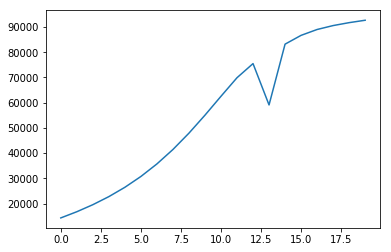

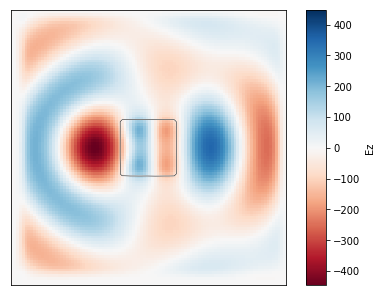

In [22]:
# It is both faster and more stable; still, the results are exactly the same because the Born computation was 
# essentially converged (maximum convergence was still ~1e-6)
plt.imshow(simulation.eps_r)
plt.colorbar()
plt.show()
plt.plot(obj_fns)
plt.show()
(convergence_array) = _solve_nl(simulation, b, kerr_nonlinearity, nl_region, kerr_nl_de, solver='newton')
simulation.plt_re(outline=True, cbar=True);

In [23]:
# Finally let's try using the "previous" fields instead of starting from the linear solution at every step
# Reset simulation
simulation.reset_eps(eps_r)
# Use Born
Nsteps = 20
obj_fns = run_optimization(simulation, b, J, dJdE, design_region, Nsteps, eps_max, kerr_nonlinearity, nl_region,
                           kerr_nl_de, solver='born', step_size=0.001, field_start='previous')

 50% (10 of 20) |############            | Elapsed Time: 0:00:20 ETA:   0:00:32

the simulation did not converge, reached 1.430006383921976e-10


 55% (11 of 20) |#############           | Elapsed Time: 0:00:24 ETA:   0:00:29

the simulation did not converge, reached 8.036594910133874e-10


 60% (12 of 20) |##############          | Elapsed Time: 0:00:27 ETA:   0:00:26

the simulation did not converge, reached 1.940832421562043e-08


 65% (13 of 20) |###############         | Elapsed Time: 0:00:30 ETA:   0:00:23

the simulation did not converge, reached 2.983761199918144e-07


 70% (14 of 20) |################        | Elapsed Time: 0:00:33 ETA:   0:00:19

the simulation did not converge, reached 1.6324724399641227e-06


 75% (15 of 20) |##################      | Elapsed Time: 0:00:37 ETA:   0:00:15

the simulation did not converge, reached 2.839717594312626e-10


 90% (18 of 20) |#####################   | Elapsed Time: 0:00:48 ETA:   0:00:07

the simulation did not converge, reached 2.1253684559971807e-10


 95% (19 of 20) |######################  | Elapsed Time: 0:00:51 ETA:   0:00:03

the simulation did not converge, reached 1.694821081441195e-10


100% (20 of 20) |########################| Elapsed Time: 0:00:54 ETA:  00:00:00

the simulation did not converge, reached 2.0749344693959108e-10
the simulation did not converge, reached 1.6248520248681475e-10


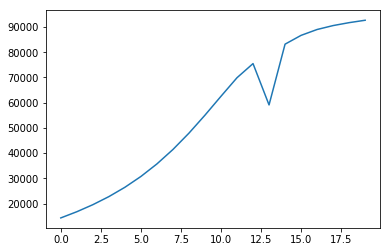

In [24]:
# Similarly (bad) stability and time... results are still the same
plt.plot(obj_fns)
plt.show()

In [32]:
# Reset simulation
simulation.reset_eps(eps_r)
# Use Newton
Nsteps = 20
obj_fns = run_optimization(simulation, b, J, dJdE, design_region, Nsteps, eps_max, kerr_nonlinearity, nl_region,
                           kerr_nl_de, solver='newton', step_size=0.001, field_start='previous')

 80% (16 of 20) |###################     | Elapsed Time: 0:00:19 ETA:   0:00:29

the simulation did not converge, reached 0.08565233991106148


100% (20 of 20) |########################| Elapsed Time: 0:00:23 ETA:  00:00:00

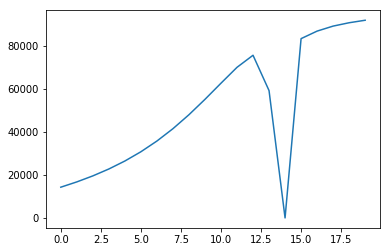

In [33]:
# Interestingly this is actually worse (less stable)... 
# Might be better with a smaller step size, let's leave the option for now
plt.plot(obj_fns)
plt.show()